In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import smogn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option("display.float_format", lambda x: f"{x:5f}")
shap.initjs()


In [2]:
# load dataset
df = pd.read_csv("./data/suanfarma_train_data.csv")
# remove useless column batch id
df.drop(["id", "Unnamed: 0"], axis=1, inplace=True)
# remove duplicate cols, possible cleaning phases (95 upwards and 5 downwards), stdev, min, max, mean, percentiles and sensors 306TI, 306LI and 101LI
df = df[df.columns.drop(df.filter(regex=".1_$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_100$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_99$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_98$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_95$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_0$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_1$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_2$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_5$").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_std").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_min").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_max").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_mean").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_75%").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_25%").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="_50%").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="306TI").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="306LI").columns.tolist())]
df = df[df.columns.drop(df.filter(regex="101LI").columns.tolist())]
# remove index and result columns
cols = sorted(df.columns)
if "result" in cols:
    cols.remove("result")
if "index" in cols:
    cols.remove("index")
# compute delta features with the remaining columns
for sensor in set(map(lambda x: x[:-3], cols)):
    for i in range(90, 10, -10):
        df[f"{sensor}_{i}__{sensor}_{i-10}"] = (
            df[f"{sensor}_{i}"] - df[f"{sensor}_{i-10}"]
        )
# defrag df
df = df.copy()


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Original Train: 37 Test: 55


synth_matrix: 100%|##########| 3/3 [00:05<00:00,  1.79s/it]


Original + Syntethic Train: 64 Test: 55


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


y test values: [0.797273 0.745263 0.75598  0.717378 0.787628 0.73236  0.74227  0.689195
 0.759326 0.725136 0.764365 0.694928 0.767121 0.732733 0.790759 0.753165
 0.674692 0.780696 0.754128 0.776947 0.789397 0.764263 0.762214 0.773325
 0.690366 0.772566 0.78597  0.745981 0.74223  0.784648 0.728224 0.751144
 0.805662 0.751262 0.769276 0.736855 0.766614 0.764846 0.787162 0.753655
 0.735573 0.698975 0.750224 0.619862 0.763551 0.761986 0.769883 0.733379
 0.795917 0.732442 0.738917 0.702676 0.728726 0.72792  0.738137]
y pred values: [0.749898 0.722799 0.73672  0.739    0.741422 0.745171 0.73992  0.747708
 0.71755  0.745604 0.741336 0.732166 0.743822 0.749208 0.722754 0.744239
 0.756043 0.746311 0.741828 0.736804 0.701557 0.744306 0.740888 0.735343
 0.740867 0.754437 0.756282 0.746841 0.74664  0.752712 0.719599 0.751633
 0.751775 0.749998 0.732114 0.75024  0.749863 0.717662 0.732668 0.751145
 0.706251 0.739    0.746655 0.722101 0.697291 0.742883 0.74835  0.743887
 0.746221 0.726492 0.730159 0

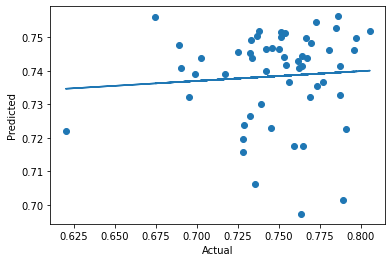

In [3]:
# train-test split
df_test = df.sample(frac=0.6, random_state=0)
df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
print(f"Original Train: {len(df_train)}", f"Test: {len(df_test)}")

# conduct smogn
df_train = smogn.smoter(
    data=df_train,
    y="result",
    samp_method="extreme",
    drop_na_col=True,
    drop_na_row=True,
    rel_thres=0.90,
)
print(f"Original + Syntethic Train: {len(df_train)}", f"Test: {len(df_test)}")

X_train = df_train.drop(["result"], axis=1)
y_train = df_train["result"].ravel()
X_test = df_test.drop(["result"], axis=1)
y_test = df_test["result"].ravel()

regr = RandomForestRegressor(random_state=0, n_estimators=45, oob_score=True)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("y test values:", y_test.round(6))
print("y pred values:", y_pred.round(6))
print("r_score", r2_score(y_test, y_pred))
print("Random Forest MSError", np.mean((y_pred - y_test) ** 2))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
# regression line
y_test, y_predicted = y_test.reshape(-1, 1), y_pred.reshape(-1, 1)
ax.plot(y_test, LinearRegression().fit(y_test, y_pred).predict(y_test))
plt.show()


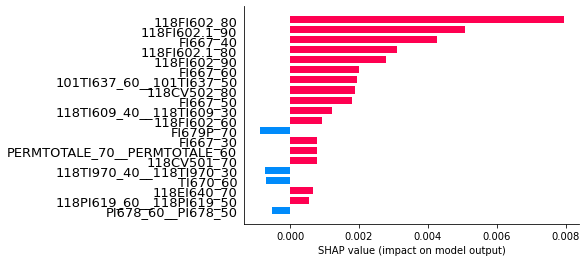

In [4]:
expl = shap.Explainer(regr, X_train)

shap.bar_plot(
    expl.shap_values(X_test.iloc[0]), feature_names=X_train.columns, max_display=20
)


In [5]:
shap.force_plot(
    expl.expected_value,
    expl.shap_values(X_test.iloc[0]),
    feature_names=X_train.columns,
)


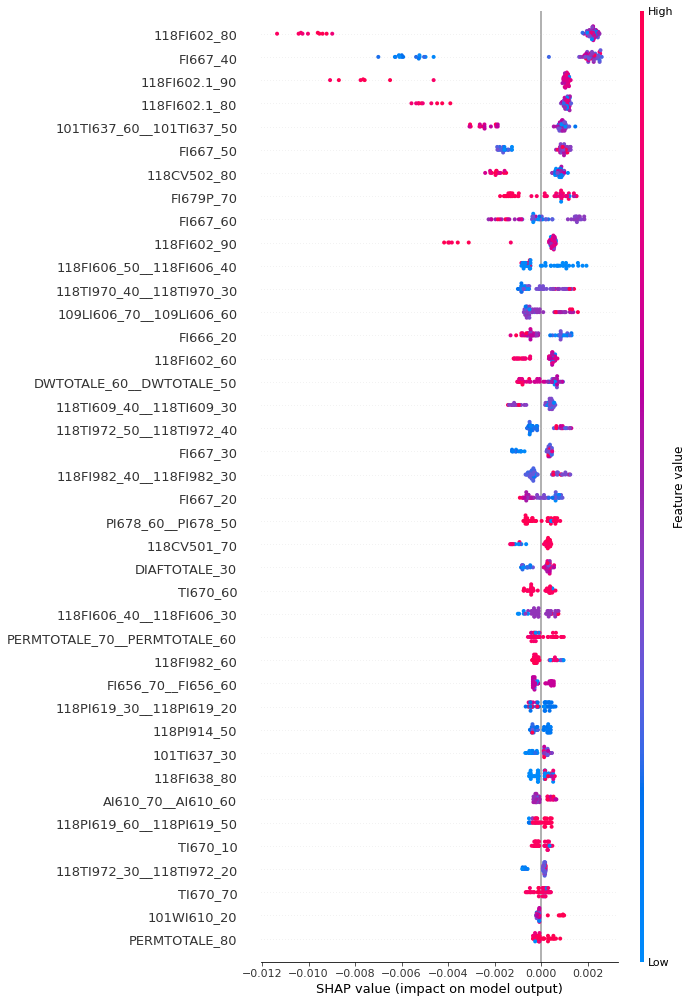

In [6]:
expl = shap.Explainer(regr, X_test)

shap.summary_plot(
    expl.shap_values(X_test),
    features=X_test,
    feature_names=X_test.columns,
    max_display=40,
)


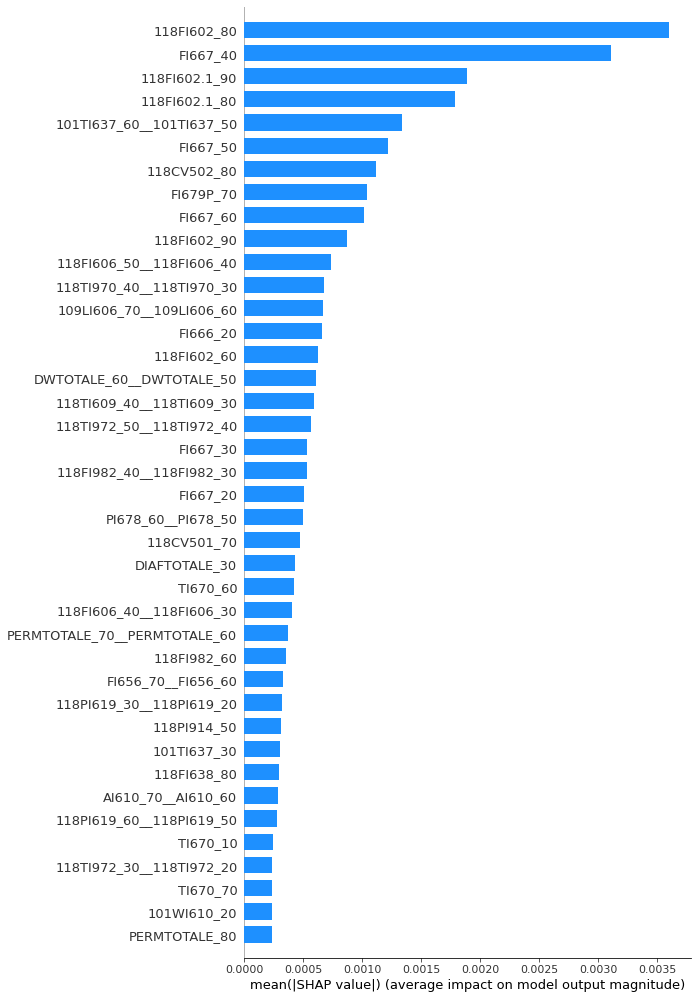

In [7]:
shap.summary_plot(
    expl.shap_values(X_test),
    feature_names=X_test.columns,
    plot_type="bar",
    color="dodgerblue",
    max_display=40,
)


synth_matrix: 100%|##########| 4/4 [00:13<00:00,  3.42s/it]
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Original + Syntethic Dataframe: 176
y test values: [0.795917 0.738855 0.797273 0.728224 0.735573 0.761986 0.762214 0.694928
 0.674692 0.722995 0.706465 0.728726 0.763869 0.787628 0.777815 0.698975
 0.717378 0.750224 0.769276 0.738927 0.744529 0.762984 0.75598  0.738137
 0.73236  0.698774 0.767121 0.751262 0.738917 0.668388 0.776947 0.751314
 0.731539 0.745263 0.732442 0.72792  0.793545 0.709416 0.763551 0.690905
 0.619862 0.789397 0.790759 0.773325 0.802097 0.764365 0.739714 0.757546
 0.733379 0.725297 0.702676 0.754128 0.740721 0.766614 0.764263 0.736855
 0.78597  0.729074 0.764762 0.753655 0.74227  0.787162 0.740607 0.753165
 0.729733 0.752038 0.785081 0.712901 0.725136 0.756932 0.757752 0.751144
 0.774452 0.735281 0.772566 0.745981 0.689195 0.690366 0.763583 0.732733
 0.759326 0.74223  0.805662 0.711897 0.784648 0.769883 0.765773 0.780696
 0.770969 0.728959 0.747496 0.764846 0.619666 0.619296 0.619473 0.620214
 0.619484 0.620063 0.620243 0.620898 0.620009 0.619581 0.620882 0.619781


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


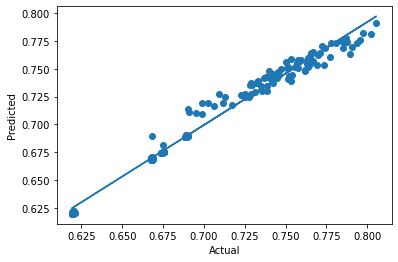

In [8]:
# conduct smogn
df_mixed = smogn.smoter(
    data=df,
    y="result",
    k=5,
    samp_method="extreme",
    drop_na_col=True,
    drop_na_row=True,
    rel_thres=0.90,
)
df_mixed.reset_index(inplace=True)
print(f"Original + Syntethic Dataframe: {len(df_mixed)}")

X = df_mixed.drop(["result"], axis=1)
y = df_mixed["result"].ravel()

regr = RandomForestRegressor(random_state=0, n_estimators=45, oob_score=True)
regr.fit(X, y)
y_pred = regr.predict(X)
print("y test values:", y.round(6))
print("y pred values:", y_pred.round(6))
print("r_score", r2_score(y, y_pred))
print("Random Forest MSError", np.mean((y_pred - y) ** 2))

fig, ax = plt.subplots()
ax.scatter(y, y_pred)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
# regression line
y, y_predicted = y.reshape(-1, 1), y_pred.reshape(-1, 1)
ax.plot(y, LinearRegression().fit(y, y_pred).predict(y))
plt.show()


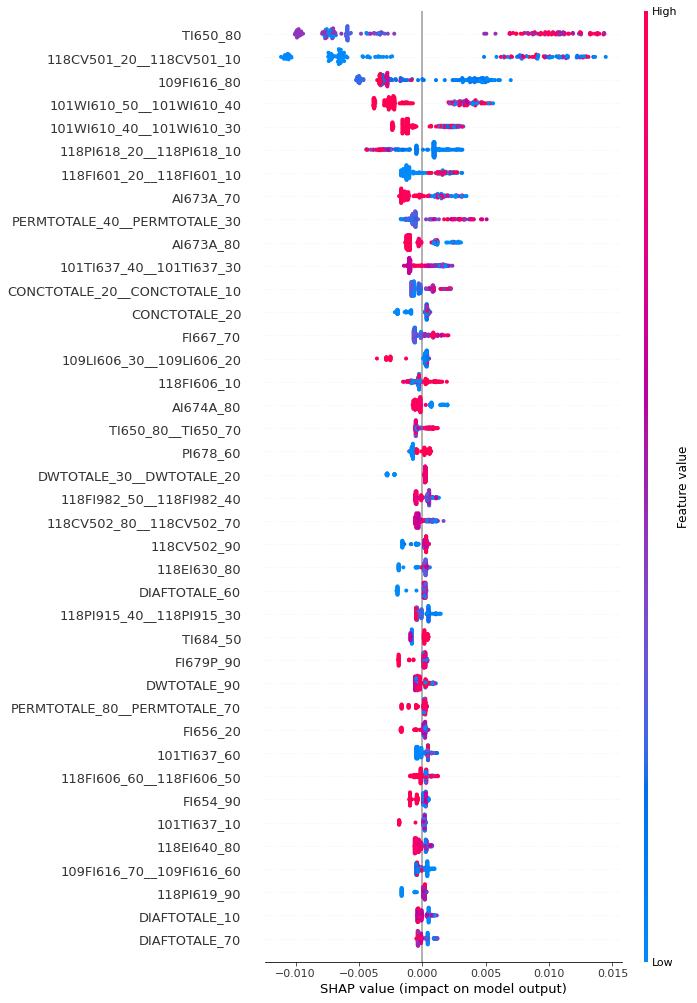

In [9]:
expl = shap.Explainer(regr, X)

shap.summary_plot(
    expl.shap_values(X), features=X, feature_names=X.columns, max_display=40
)
